# Scalable Nearest Neighbour Algorithms for High Dimensional Data

__*Please read the documentation.pdf i have provided in folder before reading this notebook for getting a better understanding of what i did* __

- I have imported three modeles named __kmeans_Knn,common_function,common_function__ from the same file to avoid clumsiness of code. you can check them. They are present in same folder .
- I wrote those files in such a way that you can understand their functionality by reading name of the function. If you have read documentation.pdf  

In [ ]:
import kmeans_Knn as kk

import randomized_multiple_kdtreed as rmk
import common_function as cf
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import threading
import heapq
%matplotlib inline



result = []
    
def kmeans_tree_multithreading(data,y,test_data,test_y,k = 3,no_of_comparisions = 10,clustring_iteration = 7,threads = 3) :
    global result
    result = []
    no_of_rows = int(len(data)/threads)
    t = []
    
    
    for i in range(threads) :
        lock = threading.Lock()
        t.append(threading.Thread(target=kmeans_tree, args=(data[no_of_rows*i:no_of_rows*(i+1)],y[no_of_rows*i:no_of_rows*(i+1)],test_data,test_y,k,no_of_comparisions,clustring_iteration,True,lock)))
    
    for t_temp in t :
        t_temp.start()
    
    for t_temp in t :
        t_temp.join()
    print(len(result[0]))
    heapq.heapify(result)
    acc = 0
    for i in range(len(test_y)) :
        if test_y[i] == min([result[j][i] for j in range(threads)],key = lambda x : x[0])[1][1][1] :
            acc += 1
    #print("accuracy : ",(acc/len(test_y))*100)
    
    #print("Done!")
    return (acc/len(test_y))*100

def multi_kdtree(data,y,test_data,test_y,no_of_trees = 5,no_of_dimensions = 600,variance = False,comparisions = 4) :
    a = time.time()
    multi_trees = rmk.randomized_trees(np.array(data),label = y,no_of_trees = no_of_trees,no_of_dimensions = no_of_dimensions,variance = variance,comparisions = comparisions )
    multi_trees.make_data_sets()
    multi_trees.make_tree()
    accuracy = []
    b = time.time()
    tree_building_time = b-a
    a = time.time()
    
    #print(test_y)
    for temp_x,temp_y in zip(test_data,test_y) :
        #print(temp_x)
        lst = [val[1] for val in multi_trees.get_nearest(temp_x)]
        #print(lst)
        if temp_y == max(set(lst), key=lst.count) :
            accuracy.append(1)
        else :
            accuracy.append(0)
       
            
    b = time.time()
    prediction_time = b-a
    
    return (sum(accuracy)/len(test_data))*100,tree_building_time,prediction_time  

def kmeans_tree(data,y,test_data,test_y,k = 3,no_of_comparisions = 100,clustring_iteration = 7,multithreading = False,lock = None):
    global result
    
    a =time.time() 
    loc_kk = kk.nary_tree(data,y,k,no_of_comparisions,clustring_iteration)
    loc_kk.make_tree()
    accuracy = []
    b = time.time()
    tree_building_time = b-a
    a = time.time()
    if multithreading == False :
        for temp_x,temp_y in zip(test_data,test_y) :
            
            if temp_y == loc_kk.get_nearest(temp_x)[0][1][1]:
                accuracy.append(1)
            else :
                accuracy.append(0)
    if multithreading == True :
        lock.acquire()
        temp_result = []
        for temp_x,temp_y in zip(test_data,test_y) :
            temp = loc_kk.get_nearest(temp_x)
            temp_result.append(temp)
            if temp_y == temp[0][1][1]:
                accuracy.append(1)
            else :
                accuracy.append(0)
        result.append(temp_result) 
        lock.release()
    b = time.time()
    prediction_time = b-a
    
    return (sum(accuracy)/len(test_data))*100,tree_building_time,prediction_time  

def single_kdtree(data,y,test_data,test_y,cols,compare) :
    a = time.time() 
    loc_rmk = rmk.knn_kdtree(data,y,cols,compare)
    loc_rmk.make_tree()
    accuracy = []
    b = time.time() 
    tree_building_time = b-a
    a = time.time() 
    for temp_x,temp_y in zip(test_data,test_y) :
        if temp_y == loc_rmk.get_nearest(temp_x)[0][1]:
            accuracy.append(1)
        else :
            accuracy.append(0)
 
    b = time.time() 
    prediction_time = b-a
    return (sum(accuracy)/len(test_data))*100,tree_building_time,prediction_time  

if __name__ == "__main__" :
    data = pd.read_csv("train.csv")
    y = data.loc[:1000,"label"].values.tolist()
    points = data.loc[:1000,"pixel0":].values.tolist()
    search_point = data.loc[1100:1150,"pixel0":].values.tolist()
    search_y = data.loc[1100:1150,"label"].values.tolist()
    collect_data = []
    

In the below cell output observe the kmeans_tree_accuracy 
- it is less because i have used the minimal parameter for prediction 

In [16]:
multi_kdtree_accuracy,treebuilding_time,prediction_time=multi_kdtree(points,y,search_point,search_y,no_of_trees = 4,no_of_dimensions = 784,variance = False,comparisions = 4)
print("multi_kdtree accuracy : ",multi_kdtree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)
single_kdtree_accuracy,treebuilding_time,prediction_time = single_kdtree(points,y,search_point,search_y,784,10)
print("single_kdtree accuracy : ",single_kdtree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)
kmeans_tree_accuracy,treebuilding_time,prediction_time = kmeans_tree(points,y,search_point,search_y,k = 3,no_of_comparisions = 1,clustring_iteration = 1)
print("kmeans_tree accuracy : ",kmeans_tree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)

multi_kdtree accuracy :  88.23529411764706 tree building time :  0.5567996501922607 prediction time :  11.713395118713379
single_kdtree accuracy :  70.58823529411765 tree building time :  0.07813668251037598 prediction time :  2.1542835235595703
kmeans_tree accuracy :  66.66666666666666 tree building time :  0.4766721725463867 prediction time :  0.4538125991821289


In this cell if we observe the accuracy there is a drastic change from above cell .This is beacuse of increased comparisions while traversing and iterations while K-means clustering.

_i just wanted to demonstrate how parameter tuning works on k-mean tree method _

In [18]:
multi_kdtree_accuracy,treebuilding_time,prediction_time=multi_kdtree(points,y,search_point,search_y,no_of_trees = 4,no_of_dimensions = 784,variance = False,comparisions = 10)
print("multi_kdtree accuracy : ",kmeans_tree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)
single_kdtree_accuracy,treebuilding_time,prediction_time = single_kdtree(points,y,search_point,search_y,784,10)
print("single_kdtree accuracy : ",kmeans_tree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)
kmeans_tree_accuracy,treebuilding_time,prediction_time = kmeans_tree(points,y,search_point,search_y,k = 3,no_of_comparisions = 30,clustring_iteration = 10)
print("kmeans_tree accuracy : ",kmeans_tree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)

multi_kdtree accuracy :  86.27450980392157 tree building time :  0.6096396446228027 prediction time :  13.834370136260986
single_kdtree accuracy :  86.27450980392157 tree building time :  0.08522963523864746 prediction time :  2.4488768577575684
kmeans_tree accuracy :  82.35294117647058 tree building time :  0.6915194988250732 prediction time :  2.555598497390747


In [7]:
collect_data = []
for j in [1,10,20,50,100,300,600,1000] : 
    for i in [1,10,100,300] : 
        kmeans_tree_accuracy,treebuilding_time,prediction_time = kmeans_tree(points,y,search_point,search_y,k = 3,no_of_comparisions = j,clustring_iteration = i+1)
        print(kmeans_tree_accuracy,treebuilding_time,prediction_time)
        temp = {"iter" : i+1,"comparisions" : j,"accuracy" : kmeans_tree_accuracy,"buid_time" : treebuilding_time,"pred_time" : prediction_time}
        collect_data.append(temp)

1001 1001
68.62745098039215 0.5529406070709229 0.4925196170806885
1001 1001
76.47058823529412 0.5562336444854736 0.6146035194396973
1001 1001
74.50980392156863 0.8202104568481445 0.5034723281860352
1001 1001
80.3921568627451 0.5747601985931396 0.4667942523956299
1001 1001
90.19607843137256 0.5374722480773926 1.0465998649597168
1001 1001
74.50980392156863 0.5284545421600342 0.992241621017456
1001 1001
80.3921568627451 0.5453503131866455 0.947476863861084
1001 1001
88.23529411764706 0.5549521446228027 1.0960450172424316
1001 1001
86.27450980392157 0.5407304763793945 1.6828124523162842
1001 1001
84.31372549019608 0.5242640972137451 1.614121913909912
1001 1001
86.27450980392157 0.6492626667022705 1.640073299407959
1001 1001
82.35294117647058 0.5638041496276855 1.79032301902771
1001 1001
88.23529411764706 0.5209789276123047 3.6200790405273438
1001 1001
88.23529411764706 0.523123025894165 3.2831945419311523
1001 1001
88.23529411764706 0.5466947555541992 3.5270042419433594
1001 1001
88.235294

- This graph shows how accuracy is varying with increasing number of iterations while clustering reason for stabelization of accuracy after some iterations is because after n iterations clustering becomes stable and what ever changes comes after that point are minute.So, after n iteratins structure of cluster does not effect the accuracy so much. As a result number of iterations stop effecting accuracy .
![images/oroginal_iteration_accuracy.png](images/oroginal_iteration_accuracy.png)
- I completely agree that my plottings in below cell does not exactly match with original plot in this cell. It is because i used K-Means clustering from sklearn which is too good that it is clustering the data in 2 to 3 iterations .
Though i set the parameters of K-Means clustering to worst performance it is working well. :-)

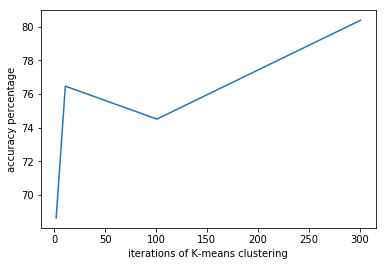

In [17]:
plt.plot([val["iter"] for val in collect_data if val["comparisions"] == 1] ,[val["accuracy"] for val in collect_data if val["comparisions"] == 1] )
plt.xlabel("iterations of K-means clustering")
plt.ylabel("accuracy percentage")

plt.savefig("iterations accuracy.png")

#### Let us analyse the time taken and accuracy of different flavours of KNN
- here we can see that normal KNN algorithm is giving highest accuracy .Ofcourse it will we cant blame that primitive standard model.
- But the problem with normal basic KNN is that it will take too much time with large datasets .
- now let us consider using trees to solve this problem this will reduce the complexity from n square to n log(n) .
- that is the reason why prediction time of single_kdtree and Kmeans_tree is 2seconds and on second respectively while accuracy of normal kmeans methid is 11 seconds.
- here multi_kd_tree is taking a lot of time because i have created 4 trees .But parallel processing of these trees will reduce time complexity drastically .


In [8]:
time_data = {}
accuracy_normal_method,time_taken = cf.normal_knn(points,y,search_point,search_y)
time_data["noraml_algo"] = {"accuracy" : accuracy_normal_method,"time" : time_taken}
print("normal_knn accuracy : ",accuracy_normal_method,"prediction time : ",time_taken)
multi_kdtree_accuracy,treebuilding_time,prediction_time=multi_kdtree(points,y,search_point,search_y,no_of_trees = 4,no_of_dimensions = 784,variance = False,comparisions = 4)
time_data["multi_kd_tree"] = {"accuracy" : multi_kdtree_accuracy,"time" : prediction_time}
print("multi_kdtree accuracy : ",multi_kdtree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)
single_kdtree_accuracy,treebuilding_time,prediction_time = single_kdtree(points,y,search_point,search_y,784,4)
time_data["single_kd_tree"] = {"accuracy" : single_kdtree_accuracy,"time" : prediction_time}
print("single_kdtree accuracy : ",single_kdtree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)
kmeans_tree_accuracy,treebuilding_time,prediction_time = kmeans_tree(points,y,search_point,search_y,k = 3,no_of_comparisions = 20,clustring_iteration = 10)
time_data["kmeans_tree"] = {"accuracy" : kmeans_tree_accuracy,"time" : prediction_time}
print("kmeans_tree accuracy : ",kmeans_tree_accuracy,"tree building time : ",treebuilding_time,"prediction time : ",prediction_time)

normal_knn accuracy :  88.23529411764706 prediction time :  11.534543514251709
multi_kdtree accuracy :  80.3921568627451 tree building time :  0.5715811252593994 prediction time :  12.638462781906128
single_kdtree accuracy :  70.58823529411765 tree building time :  0.07816600799560547 prediction time :  2.1370489597320557
1001 1001
kmeans_tree accuracy :  86.27450980392157 tree building time :  0.5326399803161621 prediction time :  1.6359894275665283


### Understanding Beautiful Plot below :

- Let us focus on kmeans_tree and normal_algo for better understanding of how trees effect accuracy and time complexity .
- here in below plot Kmeans tree is giving an accuracy of around 86 while normal algorithm is giving 88 accuracy.
- But time complexity of both can be compared in terms of log. I mean that k_means is taking 1.5(nearly log(11)) seconds to compute nearest neighbour and normal algorithm is taking 11 seconds to compute that is a huge time gap for small accuracy difference .
- Also when using really large datasets there will be enough data for Kmeans-trees to match up with accuracy of normal algorithm.
- multiple k-d trees are not giving better results .But according another research paper they perform almost equivalent to k-means tree. I think i should do further research to implement this algorithm better.
- I have tried some things to imporve performance of multiple KD trees but they did not work out .I will explain them shortly in this notebook .
- single kd tree is taking more time than K-means tree because it has binary split .So, its tree is taller than K-means tree. That is reason it is taking a more time than single_kd_tree.

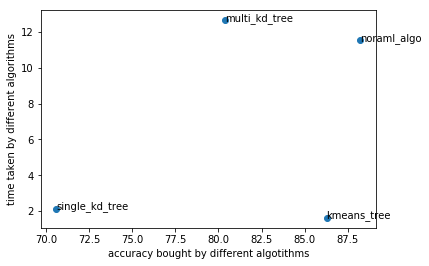

In [28]:

fig, ax = plt.subplots()
z = [val["accuracy"]for val in time_data.values()]
y = [val["time"]for val in time_data.values()]
ax.scatter(z,y, )
for i, txt in enumerate(time_data.keys()):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel("accuracy bought by different algotithms")
ax.set_ylabel("time taken by different algorithms")
plt.savefig("accuracy vs time taken")

consider n dimensions(variance) , parallel processing, explanation to code function ,write about library and what you find in notebook

### K Means using multi threading
- When we have huge amount of data like in order of 200 or 300 Gb then i will be difficult for a single computer to handle such a large data .
- To solve such problems this research paper proposes to divide data and run diffenent parallel processes in different machines and finally collect all the data and find best nearest neighbour.
- I have used multithreading in my code to demonstrate that virtually .Here i did not considered time complexity of algorithm because i am not actuually performing multiple tasks at multiple place but in same computer and one more difficulty is i have locked some of the process in multiprocessing so that different threads does not interact .

In [11]:
collect_accuracy = []
for i in [1,5,10,20,100] :
    mt_accuracy = kmeans_tree_multithreading(points,y,search_point,search_y,k = 3,no_of_comparisions = 100,clustring_iteration = 30,threads = i)
    collect_accuracy.append((mt_accuracy,i))

51
51
51
51
51


- Below graph is behaviour of multi threading with increasing number of threads
- Data i used while plotting is of constant size. I did not incremented data
- We can observe that as the number of processes increase then accuracy starts decreasing linearly.
- This behaviour is because as i am keeping the size of data set constant ,when i increase number of threads in multi threading, data is splitted equally among different processes.
- As a result each tree do not have sufficient data to atleast predict approximate correct neighbour. So accuracy decreases with increasing parallel threads.

Text(0,0.5,'Accuracy')

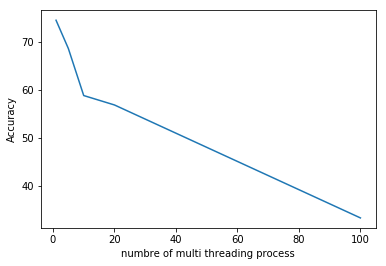

In [14]:
plt.plot([val[1] for val in collect_accuracy],[val[0] for val in collect_accuracy])
plt.xlabel("numbre of multi threading process")
plt.ylabel("Accuracy")